# A Data Exploration of the Package Ecosystem NPM

The following project is an analysis made of data related to NPM. It is made public for the sake of reproducibility of the study that was based on the findings made here.

## Tools
The tools used for this project was
- this jupyter notebook with the imports mentioned in the first code cell
- the Bash cli for cutting data
- data downloaded from https://libraries.io/data
- a Google Cloud Bucket
- a Google Cloud VM

## Instructions 

### 1. Download the data
The csv-formatted data comes from https://libraries.io/data, choose the file **libraries-1.6.0-2020-01-12.tar.gz**
Upon download of this 24GB file, decompress from googlezip and tar so that you have a filestructure containing 7 datasets. For this study, only **projects_with_repository_fields-1.6.0-2020-01-12.csv** is used.

### 2. Cut NPM data using Bash
Open bash, or zsh etc. 
cd to the containing folder and run the following scripts to obtain the NPM projects data.

<code>awk -F, '$2 ~ /NPM/' projects_with_repository_fields-1.6.0-2020-01-12.csv > ~/npm_projects.csv
head -n 1 projects_with_repository_fields-1.6.0-2020-01-12.csv > ~/head.csv
cat head.csv npm_projects.csv > only_npm_projects_w_header.csv
</code>

### 3. Read the data
To read the data I uploaded it in a Google Cloud Bucket, this can be done via tutorials online, or if my bucket is still active, you can access it there. Alternatively, you can run this project locally on your computer either by taking a sample of the csv with bash or in full by running a few columns at a time if there is a lack of memory.

### 4. Run the Notebook
Download this notebook and install all dependencies, you should then be able to run the code blocks below.

In [194]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import gcsfs
import requests
from datetime import datetime
from matplotlib.ticker import FuncFormatter

For this project I have created a GCP project to run the code on and a google cloud bucket to pull the cut data from.

In [198]:
custom_date_parser = lambda x: datetime.strptime(x, "%Y-%d-%m")

fs = gcsfs.GCSFileSystem(project='crypto-quasar-297422')
with fs.open('gs://bda_demo11/only_npm_projects_w_header.csv') as f:
    df = pd.read_csv(f, usecols=['Platform', 'Repository Fork?', 'Repository Updated Timestamp', 
                                 'Repository Homepage URL', 'Package Manager ID', 
                                 'Repository URL', 'Repository Security Audit filename'])
df.head(1)

,Platform,Repository URL,Package Manager ID,Repository Fork?,Repository Updated Timestamp,Repository Homepage URL,Repository Security Audit filename
30617,0,1,6,NaN,NaN,NaN,NaN


The dataset is misaligned column-wise, meaning that the column containing Created Timestamp, the package's date of creation, is located under the column called Name etc. Below is a correction these misaligned columns.

In [2]:
df = df.rename(columns={
    'Platform': 'Name',
    'Repository Fork?': 'Created',
    'Repository URL': 'Versions Count',
    'Repository Updated Timestamp': 'Updated',
    'Repository Homepage URL': 'Repository Size',
    'Package Manager ID': 'Dependent Projects Count',
    'Repository Security Audit filename': 'Repository Status'
})
df.head(1)

,Name,Versions Count,Dependent Projects Count,Created,Updated,Repository Size,Repository Status
30617,0,1,6,NaN,NaN,NaN,NaN


In [3]:
df['Created'] = pd.to_datetime(df['Created'], errors='coerce')
df['Updated'] = pd.to_datetime(df['Updated'], errors='coerce')
df

,Name,Versions Count,Dependent Projects Count,Created,Updated,Repository Size,Repository Status
2060124,paging.react,8,1,2017-05-07 07:18:50+00:00,2017-06-09 07:50:34+00:00,3301.0,NaN
323637,tipe-model,1,1,2014-12-21 20:06:00+00:00,2014-12-22 08:57:09+00:00,388.0,NaN
326493,ultflow,1,1,2014-07-02 00:49:02+00:00,2014-07-02 00:54:03+00:00,108.0,NaN
3677707,force-latest-versions,3,0,2019-02-13 00:49:05+00:00,2019-08-28 23:50:56+00:00,16.0,NaN
1156605,hubot-ryver,3,2,2016-01-19 17:17:48+00:00,2018-02-09 02:41:22+00:00,12.0,NaN
...,...,...,...,...,...,...,...
1478909,trail-client,3,0,2016-05-16 02:22:12+00:00,2016-05-20 06:14:15+00:00,23.0,Removed
144614,ember-rl-week-picker,6,0,2014-11-01 23:01:44+00:00,2015-08-03 19:11:13+00:00,387.0,NaN
3439963,@phantomchain/core-transaction-pool-mem,1,0,NaT,NaT,NaN,NaN
1728200,pm2-githook,13,0,2016-10-11 18:53:44+00:00,2019-10-22 12:52:24+00:00,35.0,NaN


Look at the repository size

In [4]:
sample_no_size = sample['Repository Size'].dropna()
sample_no_size.sort_values()

3791675           0.0
3183170           0.0
2757136           0.0
2578436           0.0
2460646           0.0
              ...    
982707     13438793.0
983991     13438793.0
4122370    13438793.0
2185511    13438793.0
981315     13438793.0
Name: Repository Size, Length: 778999, dtype: float64

Analyze the top 100 projects

In [193]:
sample.sort_values('Dependent Projects Count', ascending=False).head(100)

,Name,Versions Count,Dependent Projects Count,Created,Updated,Repository Size,Repository Status,Days_from_creation,Created_year,Updated_year
295363,mocha,157,207277,2011-03-07 18:44:25+00:00,2020-01-12 09:21:03+00:00,13823.0,NaN,3232.0,2011.0,2020.0
145391,eslint,241,190999,2013-06-29 23:59:48+00:00,2019-12-31 17:52:20+00:00,23450.0,NaN,2375.0,2013.0,2019.0
326120,typescript,1467,137519,2014-06-17 15:28:39+00:00,2019-12-19 23:02:32+00:00,1204830.0,NaN,2011.0,2014.0,2019.0
330445,webpack,631,128035,2012-03-10 10:08:14+00:00,2020-01-03 23:42:23+00:00,30228.0,NaN,2855.0,2012.0,2020.0
570149,babel-core,263,126919,2014-09-28 13:38:23+00:00,2020-01-14 00:22:20+00:00,46128.0,NaN,1933.0,2014.0,2020.0
...,...,...,...,...,...,...,...,...,...,...
279891,estraverse,31,1220,2012-10-09 18:21:16+00:00,2019-08-13 22:09:13+00:00,171.0,NaN,2499.0,2012.0,2019.0
182901,protobufjs,136,1220,2013-03-01 18:46:54+00:00,2019-12-20 21:20:57+00:00,37321.0,NaN,2485.0,2013.0,2019.0
2510086,@babel/types,58,1220,2014-09-28 13:38:23+00:00,2020-01-14 00:22:20+00:00,46128.0,NaN,1933.0,2014.0,2020.0
177618,null-loader,4,1218,2014-07-23 20:36:45+00:00,2019-05-15 13:16:52+00:00,379.0,NaN,1756.0,2014.0,2019.0


Preprocess data, creating the new Days from creation column by taking the (Updated date - Created date) for each row

In [7]:
def discard_time_from_date_string (string):
    split_string_by_space = string.split(" ", 1)
    return split_string_by_space[0]

def days_between_dates (date1, date2):
    return (date2 - date1).days

df['Days_from_creation'] = df.apply(lambda x: days_between_dates(x['Created'], x['Updated']), axis=1)

df['Days_from_creation'].value_counts

<bound method IndexOpsMixin.value_counts of 2060124      33.0
323637        0.0
326493        0.0
3677707     196.0
1156605     751.0
            ...  
1478909       4.0
144614      274.0
3439963       NaN
1728200    1105.0
3446803      45.0
Name: Days_from_creation, Length: 1277220, dtype: float64>

Take the years of which they were updated and created and save in new columns for later comparison

In [8]:
df['Created_year'] = df.apply(lambda x: x['Created'].year, axis=1)
df['Updated_year'] = df.apply(lambda x: x['Updated'].year, axis=1)

2060124    2017.0
323637     2014.0
326493     2014.0
3677707    2019.0
1156605    2016.0
            ...  
1478909    2016.0
144614     2014.0
3439963       NaN
1728200    2016.0
3446803    2018.0
Name: Created_year, Length: 1277220, dtype: float64

In [43]:
a= df.sort_values('Created', ascending=False)
a['Created'].dropna()

4793656   2020-01-14 23:02:41+00:00
4793676   2020-01-14 22:45:46+00:00
4793628   2020-01-14 22:40:04+00:00
4793630   2020-01-14 22:39:21+00:00
4793670   2020-01-14 22:21:20+00:00
                     ...           
1475985   2008-04-11 02:19:47+00:00
3626793   2008-04-11 02:19:47+00:00
2727338   2008-03-27 02:15:03+00:00
2885180   2008-03-10 14:45:35+00:00
1058199   2008-03-06 04:10:02+00:00
Name: Created, Length: 784418, dtype: datetime64[ns, UTC]

The following is Fig 1 used in the study

In [ ]:
series = df['Created'].dropna()
print(len(series))
plt.style.use('ggplot')
from matplotlib.ticker import FuncFormatter

n_bins = 60 #approximately the number of months

fig, ax = plt.subplots(figsize=(8, 6))

# plot the cumulative and non-cumulative histogram
ax.hist(series, n_bins, cumulative=True, label='Cumulative')
ax.hist(series, n_bins, cumulative=False, label='Per month')

# Force y-axis to display frequency
ax.yaxis.set_major_formatter(FuncFormatter(lambda x, pos: ('%.f')%(x)))

# Tidy up the figure
ax.grid(True)
ax.legend(loc='upper left')
ax.set_title('Accumulative growth of NPM packages since 2015')
ax.set_xlabel('Time')
ax.set_ylabel('NPM packages created')

plt.show()

In [27]:
sample['Updated_year'].value_counts()

2019.0    235309
2018.0    146925
2017.0    134657
2016.0    100068
2015.0     60180
2020.0     52433
2014.0     28530
2013.0     12244
2012.0      4262
2011.0      1089
2010.0        83
2009.0         7
2008.0         2
Name: Updated_year, dtype: int64

The following is the same graph, using only NPM data, a smaller subset of the data.

784418


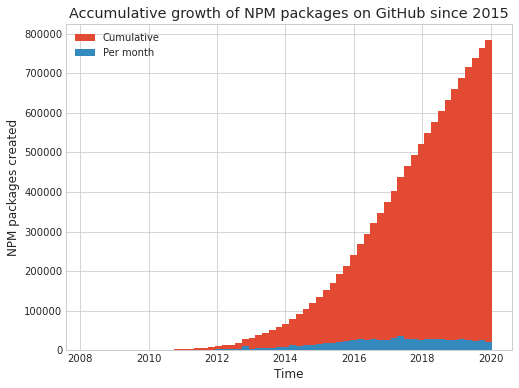

In [190]:
series = df['Created'].dropna()
print(len(series)) # See how what n is equal to
plt.style.use('seaborn-whitegrid')
from matplotlib.ticker import FuncFormatter

n_bins = 60

fig, ax = plt.subplots(figsize=(8, 6))

# plot histograms
ax.hist(series, n_bins, cumulative=True, label='Cumulative')
ax.hist(series, n_bins, cumulative=False, label='Per month')

# Force y-axis to display quantity
ax.yaxis.set_major_formatter(FuncFormatter(lambda x, pos: ('%.f')%(x)))
# tidy up the figure
ax.grid(True)
ax.legend(loc='upper left')
ax.set_title('Accumulative growth of NPM packages on GitHub since 2015')
ax.set_xlabel('Time')
ax.set_ylabel('NPM packages created')

plt.show()

Preprocessing and plotting of Fig 6 in the essay, box plot of date_from_creation

In [1]:
# Take days from creation for every year, remove the few inaccurate values (n=3340) also shown below
def remove_from_lists(year):
    a = df[df['Created_year'] == year]['Days_from_creation'].dropna()
    return [item for item in a if item >= 0]
    

p2010 = remove_from_lists(2010)
p2011 = remove_from_lists(2011)
p2012 = remove_from_lists(2012)
p2013 = remove_from_lists(2013)
p2014 = remove_from_lists(2014)
p2015 = remove_from_lists(2015)
p2016 = remove_from_lists(2016)
p2017 = remove_from_lists(2017)
p2018 = remove_from_lists(2018)

plot_data = [p2010, p2011, p2012, p2013, p2014, p2015, p2016, p2017, p2018]

NameError: name 'sample' is not defined

In [208]:
df.sort_values('Days_from_creation')
s= df[df['Days_from_creation'] < 0]
s

1017


,Name,Versions Count,Dependent Projects Count,Created,Updated,Repository Size,Repository Status,Days_from_creation,Created_year,Updated_year
2312342,syntax-error-plus,1,0,2017-06-05 18:56:43+00:00,2017-03-01 22:45:12+00:00,19.0,NaN,-96.0,2017.0,2017.0
2274886,arabic-antd-mobile,6,0,2017-05-07 16:22:42+00:00,2017-05-07 03:07:55+00:00,56468.0,NaN,-1.0,2017.0,2017.0
2438520,vs-allmighty-autocomplete,1,0,2017-09-15 12:41:24+00:00,2017-03-12 17:21:11+00:00,683.0,NaN,-187.0,2017.0,2017.0
4744483,ckeditor5-build-classic-base64-upload-adapter,2,0,2019-12-13 02:21:08+00:00,2019-12-09 15:31:21+00:00,16293.0,NaN,-4.0,2019.0,2019.0
3333137,dash42,1,0,2018-10-11 01:28:20+00:00,2018-09-13 01:08:31+00:00,3.0,NaN,-29.0,2018.0,2018.0
...,...,...,...,...,...,...,...,...,...,...
2351174,ts-antd-react-form-builder,1,0,2017-06-29 09:00:41+00:00,2017-05-08 02:20:33+00:00,545.0,NaN,-53.0,2017.0,2017.0
3193855,jameskit,1,0,2018-07-31 18:46:23+00:00,2018-07-31 10:23:01+00:00,37118.0,NaN,-1.0,2018.0,2018.0
4792132,capacitor-codepush,4,0,2020-01-11 08:42:04+00:00,2019-12-27 23:12:24+00:00,1747.0,NaN,-15.0,2020.0,2019.0
1563349,jquery-splendid-textchange,1,0,2016-07-02 15:54:04+00:00,2013-06-18 18:24:01+00:00,116.0,NaN,-1110.0,2016.0,2013.0


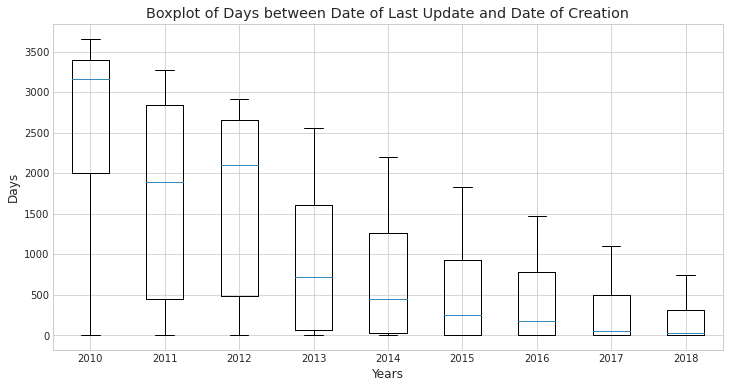

In [184]:
#create boxplot
fig = plt.figure(1, figsize=(12, 6))

# Create an axes instance
ax = fig.add_subplot(111)

# Create the boxplot
bp = ax.boxplot(plot_data, vert = True, labels = ['2010', '2011', '2012','2013', '2014', '2015','2016', '2017', '2018'])
#bp = ax.boxplot(plot_data)
ax.yaxis.set_major_formatter(FuncFormatter(lambda x, pos: ('%.f')%(x)))
# Save the figure
fig.savefig('fig1.png', bbox_inches='tight')
ax.set_title('Boxplot of Days between Date of Last Update and Date of Creation')
ax.set_xlabel('Years')
ax.set_ylabel('Days')

plt.show()

100


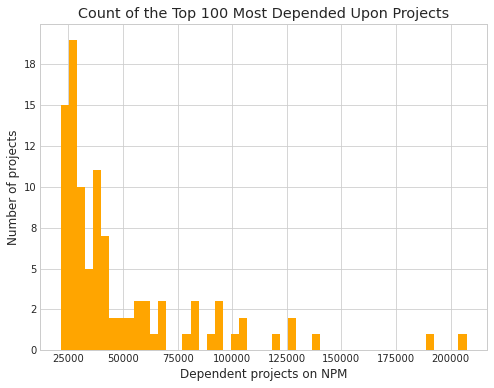

In [187]:
#Fig 2

series = df.sort_values('Dependent Projects Count', ascending=False).head(100)['Dependent Projects Count'].dropna()

print(len(series))
plt.style.use('seaborn-whitegrid')

n_bins = 50

fig, ax = plt.subplots(figsize=(8, 6))

# plot the cumulative histogram
ax.hist(series, n_bins, color="orange")

# Force y-axis to display quantity

ax.yaxis.set_major_formatter(FuncFormatter(lambda x, pos: ('%.f')%(x)))
# tidy up the figure
ax.grid(True)

ax.set_title('Count of the Top 100 Most Depended Upon Projects')
ax.set_xlabel('Dependent projects on NPM')
ax.set_ylabel('Number of projects')

plt.show()

100


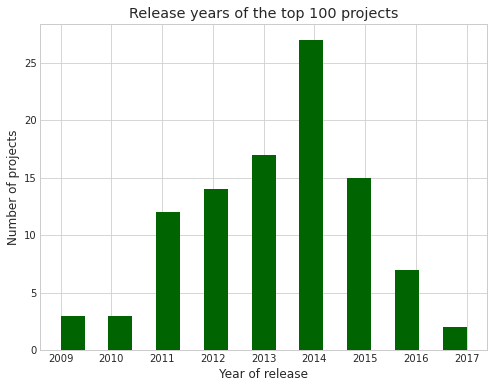

In [188]:
#Fig 3

series = df.sort_values('Dependent Projects Count', ascending=False).head(100)['Created_year'].dropna()

print(len(series))
plt.style.use('seaborn-whitegrid')
from matplotlib.ticker import FuncFormatter

#zero_to_thousand = 

n_bins = 17

fig, ax = plt.subplots(figsize=(8, 6))

# plot the cumulative histogram
ax.hist(series, n_bins, color="darkgreen")

# Force y-axis to display quantity

ax.yaxis.set_major_formatter(FuncFormatter(lambda x, pos: ('%.f')%(x)))
# tidy up the figure
ax.grid(True)

ax.set_title('Release years of the top 100 projects')
ax.set_xlabel('Year of release')
ax.set_ylabel('Number of projects')

plt.show()

32279


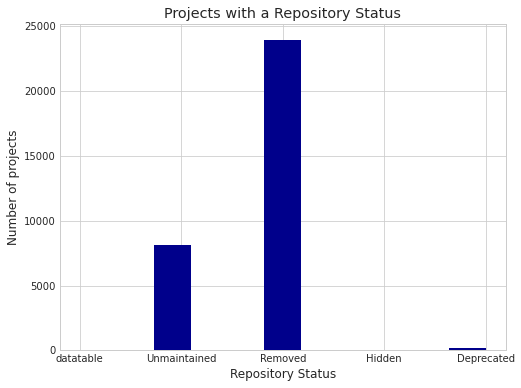

In [189]:
#Fig 6

series = df.sort_values('Repository Status', ascending=False)['Repository Status'].dropna()
series.value_counts()

print(len(series))
plt.style.use('seaborn-whitegrid')
from matplotlib.ticker import FuncFormatter

#zero_to_thousand = 

n_bins = 11#number of months

fig, ax = plt.subplots(figsize=(8, 6))

# plot the cumulative histogram
ax.hist(series, n_bins, color='darkblue')

# Force y-axis to display quantity

ax.yaxis.set_major_formatter(FuncFormatter(lambda x, pos: ('%.f')%(x)))
# tidy up the figure
ax.grid(True)

ax.set_title('Projects with a Repository Status')
ax.set_xlabel('Repository Status')
ax.set_ylabel('Number of projects')

plt.show()